# Path Planning On a Grid

![1](./Image/1.png)

In this lab we consider the problem of finding a (shortest) path on a graph of special structure, widely used in robotics and computer games, i.e. a grid. Grid is composed of the free and blocked cells and an agent may move from one free cell to the other. The connectivity of the grid may vary, e.g. grid might be 4-connected when only cardinal moves are allowed, 8-connected when diagonal moves are allowed as well, etc. 

**In this lab we assume that the grid can be either 4-connected or 8-connected**. When grid is 4-connected only moves into the cardinal directions (N,E,W,S) are allowed. The cost of each move is uniform, i.e. 1. When grid is 8-connected diagonal moves are additionally allowed. The cost of diagonal moves is sqrt(2). 

We will consider two algorithms for grid-based pathfinding: `Dijkstra`'s algorithm and `A*`. Both of these algorithms can be implemented in a way that the difference might seem negligible. I.e. `Dijkstra`'s algorithm uses g-values to prioritize search-nodes in OPEN, while `A*` do this by utilizing f-values, where f(n)=g(n)+h(n), where h(n) is an admissible heuristic. This subtle difference, however, might severely influence the performance as will see further on.

So let's go for it!

![2](./Image/2.png)

You task is to implement `Dijkstra` and `A*` by filling up the missing parts of the code. 

Run every cell of the notebook, completing the tasks described in them. Good luck!

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from sys import float_info
EPS = float_info.epsilon
%matplotlib inline

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [2]:
class Map:

    # 
    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def ReadFromString(self, cellStr, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self.width) and (0 <= i < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[i][j]


    def GetNeighbors(self, i, j, diagonalMoves = False):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        '''   
        neighbors = []
        #TODO
        return neighbors

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In case of 4-connected grid it is always equal to 1. However if other moves are allowed, the cost of a transition may vary.

In [3]:
def ComputeCost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    else: #diagonal move
        return math.sqrt(2) 

### Search Node Representation



In [4]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, i, j, g = 0, h = 0, F = None, parent = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other): #self < other (self has higher priority)
        return self.F < other.F or (abs(self.F - other.F) < EPS and (self.g > other.g))

### Visualization

In [5]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    
    


Example of the visualization

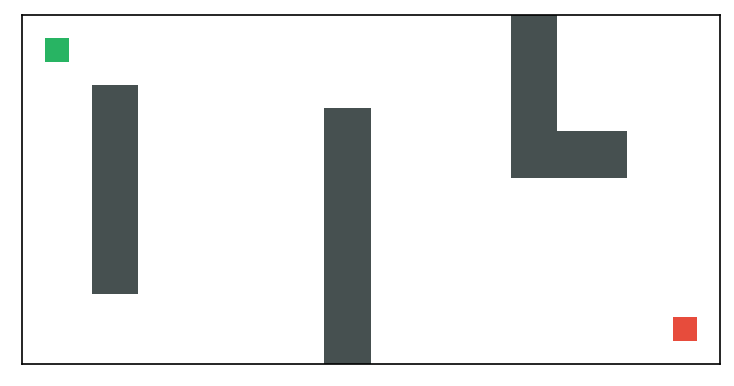

In [6]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

testMap = Map()
testMap.ReadFromString(mapstr, width, height)
start = Node(1, 1)
goal = Node(13, 28)
Draw(testMap, start, goal)



### Implementing OPEN and CLOSED
Efficient implementation of OPEN and CLOSED is crucial for any search algorithm. Below you may find basic implementations that use lists to store the elements of OPEN and CLOSED. This is not very efficient. Your task is to create your own implementations.

It's a good idea to modify CLOSED first (as it is pretty straghtforward to do so). Then check that everything is OK, i.e. the search algorithms work faster and the result is correct. Then proceed to modifying OPEN (which is not that trivial as might seem).

PS: You may wish to add additional fields, methods, method-arguments etc. to your implementations.


In [7]:
class OpenBase:

    def __init__(self):
        pass


    def __len__(self):
        pass


    def __iter__(self):
        pass


    def isEmpty(self):
        '''
        isEmpty should inform whether the OPEN is exhausted or not in the former case the search main loop should be interrupted
        '''
        pass


    def AddNode(self, node : Node, *args):
        '''
        AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
        When implementing it do not forget to handle all possible cases:
         - node already in OPEN but the new g-value is better;
         - node already in OPEN but the new g-value is worse;
         - node is not in OPEN yet.
        '''
        pass


    def GetBestNode(self, *args):
        '''
        GetBestNode is the method that 
         i) finds the best node, i.e. the one with the lowest f-value (f=g+h) (for Dijkstra h=0),
         ii) removes it from OPEN and 
         iii) returns it
        '''
        pass



In [8]:
class OpenList (OpenBase):

    def __init__(self):
        self.elements = []
    

    def __iter__(self):
        return iter(self.elements)


    def __len__(self):
        return len(self.elements)


    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True
    

    def GetBestNode(self, *args):
        bestF = math.inf
        bestCoord = 0
        for i in range(len(self.elements)):
            if self.elements[i].F < bestF:
                bestCoord = i
                bestF = self.elements[i].F
                
        best = self.elements.pop(bestCoord)
        return best
    

    def AddNode(self, node : Node, *args):
        for existingNode in self.elements:
            if existingNode.i == node.i and existingNode.j == node.j:
                if existingNode.g > node.g:
                    existingNode.g = node.g
                    existingNode.F = node.F
                    existingNode.parent = node.parent
                    return
                else:
                    return
        self.elements.append(node)
        return


In [9]:
class ClosedBase:

    def __init__(self):
        pass


    def __iter__(self):
        pass
    

    def __len__(self):
        pass
    
    
    def AddNode(self, item : Node):
        pass


    def WasExpanded(self, item : Node):
        pass



In [10]:
class ClosedList (ClosedBase):

    
    def __init__(self):
        self.elements = []


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)
    

    def AddNode(self, item : Node):
        '''
        AddNode is the method that inserts the node to CLOSED
        '''
        self.elements.append(item)
     
     
    def WasExpanded(self, item : Node):
        '''
        WasExpanded is the method that checks if a node has been expanded
        '''
        return item in self.elements

In [11]:
class YourOpen (OpenBase):
    '''
    !!!TODO!!!
    Create your own modification of OPEN#
    '''
    
    def __init__(self):
        pass
    
    def __iter__(self):
        pass
    
    def __len__(self):
        pass

    def isEmpty(self):
        pass

    def AddNode(self, *args):
        pass

    def GetBestNode(self, *args):
        pass

In [14]:
class YourClosed (ClosedBase):
    '''
    !!!TODO!!!
    Create your own modification of CLOSED#
    '''

    def __init__(self):
        pass


    def __iter__(self):
        pass
    

    def __len__(self):
        pass


    def AddNode(self, item : Node):
        pass


    def WasExpanded(self, item : Node):
        pass

### Validating the results


In [16]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [17]:
def ReadTaskFromFile(path):
    '''
    Reads map, start/goal positions and true value of path length between given start and goal from file by path. 
    '''

    tasksFile = open(path)
    count = 0
    height = int(tasksFile.readline())
    width = int(tasksFile.readline())
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in tasksFile:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    iStart = int(tasksFile.readline())
    jStart = int(tasksFile.readline())
    iGoal = int(tasksFile.readline())
    jGoal = int(tasksFile.readline())
    cardinalLength = float(tasksFile.readline())
    diagonalLength = float(tasksFile.readline())
    return (width, height, cells, iStart, jStart, iGoal, jGoal, cardinalLength, diagonalLength)

`Simpletest` tests the pathfing algorithm on a single simple instance, `Massivetest` - on a series of a move involved instances. Both tests assume that the search function fits the following pattern:


`Search(taskMap, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (pathFound, lastState, CLOSED, OPEN)`, where

- taskMap -- grid
- start.i, start.j -- (i,j) coordinates of the start cell
- goal.i, goal.j -- (i,j) coordinates of the goal cell
- *optional arguments* -- additional parameters of the search function, passed with `*args`. Example of additional parameters you can see at Dijkstra and A* functions
- pathFound -- `True` if path was found, `False` otherwise
- lastState -- last state of the path. `None` if path was not found
- CLOSED -- CLOSED set (at the last step)
- OPEN -- OPEN set (at the last step)

In [18]:
from random import randint

def SimpleTest(SearchFunction, task, *args):
    '''
    SimpleTest runs SearchFunction on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task

    '''
    
    height = 15
    width = 30
    mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    cardLengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]
    diagLengths = [31.313708498984763, 24.72792206135786, 25.89949493661167, 15.727922061357859, 23.899494936611667,\
                   21.65685424949238, 27.899494936611667, 21.72792206135786, 34.97056274847714, 18.89949493661167,\
                   30.899494936611667, 32.89949493661167, 22.414213562373096, 21.899494936611667, 32.97056274847714,\
                   28.384776310850242, 34.970562748477136, 26.82842712474619, 35.798989873223334, 30.142135623730955,\
                   28.62741699796953, 24.899494936611667, 25.970562748477146, 34.970562748477136, 35.79898987322333] 

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)


    start = Node(*starts[task])
    goal = Node(*goals[task])
    cardLength = cardLengths[task]
    diagLength = diagLengths[task]
    try:
        result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = (int(path[1])  == int(cardLength) or abs(float(path[1]) - float(diagLength)) < 1e-6)
            Draw(taskMap, start, goal, path[0], nodesExpanded, nodesOpened)
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
        else:
            print("Path not found!")

    except Exception as e:
        print("Execution error")
        print(e)

In [19]:
def MassiveTest(SearchFunction, *args):
    '''
    MassiveTest runs SearchFunction on set of differnt tasks (from directory Data/) with *args as optional arguments and for every task displays one of these short reports:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    Massive test return a dictionary with statistics of path finding. Dictionary contains next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    taskNum = 9
    taskMap = Map()
    for taskCount in range(taskNum):
        taskFileName = "Data/" + str(taskCount) + ".map"
        width, height, cells, iStart, jStart, iGoal, jGoal, cardinalLength, diagonalLength = ReadTaskFromFile(taskFileName)
        taskMap.SetGridCells(width,height,cells)
        try:
            result = SearchFunction(taskMap, iStart, jStart, iGoal, jGoal, *args)
            nodesExpanded = result[2]
            nodesOpened = result[3]
            if result[0]:
                path = MakePath(result[1]) 
                stat["len"].append(path[1])
                correct = (int(path[1])  == int(cardinalLength) or abs(float(path[1]) - float(diagonalLength)) < 1e-6)
                stat["corr"].append(correct)
                # Draw(taskMap, Node(iStart, jStart), Node(iGoal, jGoal), path[0], nodesExpanded, nodesOpened)
                print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(len(nodesOpened) + len(nodesExpanded))
            stat["st"].append(len(nodesExpanded))

        except Exception as e:
            print("Execution error")
            print(e)

    return stat

## Dijkstra algorithm

The input is:
- map
- start/goal
- heuristic function (None by defalut)
- the references to the implementation of OPEN and CLOSED (defaults are provided)

Please note, that technically there is no need to pass heuristic function to Dijkstra's algorithm. However to unify it with A* we keep this parameter as a take-in argument.

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers further on)
- OPEN and CLOSED nodes for further visualization purposes

In [20]:
def Dijkstra(gridMap : Map, iStart : int, jStart : int, iGoal : int, jGoal : int, heuristicFunction = None, openType = OpenList, closedType = ClosedList, diagonalMoves = False):
#     TODO
    OPEN = openType()
    CLOSED = closedType()
    

    return (False, None, CLOSED, OPEN)

Now let's test the implementation.

Path found! Length: 36. Nodes created: 284. Number of steps: 276. Correct: True
Wall time: 26.6 ms


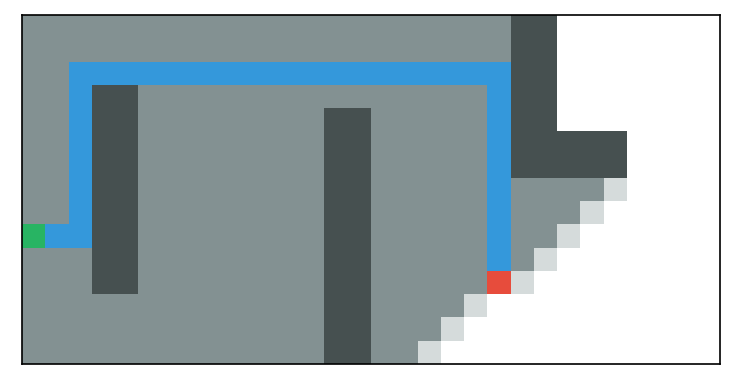

In [22]:
#This should work correct (but somewhat slow) in case your implementatation of Dijkstra is correct
%time SimpleTest(Dijkstra, 0, None, OpenList, ClosedList)

Path found! Length: 36. Nodes created: 279. Number of steps: 272. Correct: True
Wall time: 19 ms


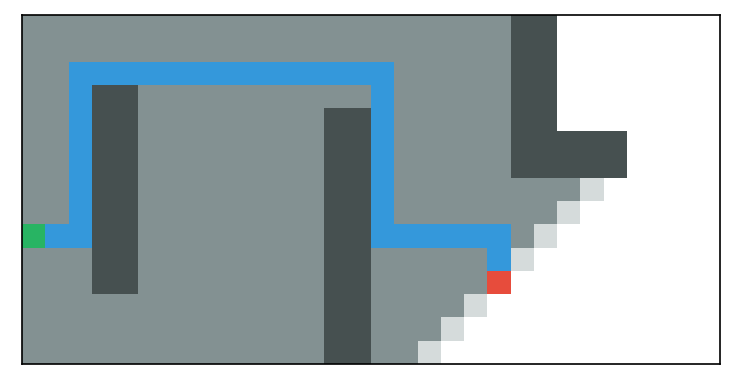

In [23]:
#This should work better (=faster) in case:
# i) your implementation of Dijkstra is correct
# ii) your implementation of OPEN/CLOSED is efficient
%time SimpleTest(Dijkstra, 0, None, YourOpen, YourClosed)

Path found! Length: 31.313708498984763. Nodes created: 287. Number of steps: 271. Correct: True
Wall time: 16.9 ms


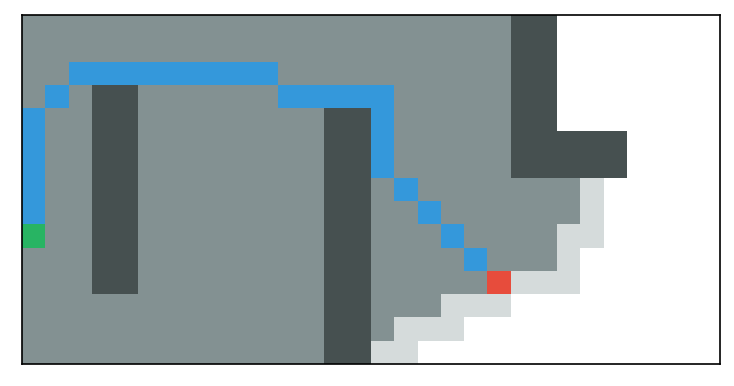

In [24]:
%time SimpleTest(Dijkstra, 0, None, YourOpen, YourClosed, True)

In [25]:
#Running Dijkstra with the default (list-based) implementation of OPEN/CLOSED will take looooots of time.
#So try running it with your (efficient) implementation of Open/Closed
%time dijkStat = MassiveTest(Dijkstra, None, YourOpen, YourClosed, False)

Path found! Length: 64. Nodes created: 1774. Number of steps: 1749. Correct: True
Path found! Length: 197. Nodes created: 7452. Number of steps: 7449. Correct: True
Path found! Length: 462. Nodes created: 45904. Number of steps: 45895. Correct: True
Path found! Length: 498. Nodes created: 44451. Number of steps: 44434. Correct: True
Path found! Length: 479. Nodes created: 47542. Number of steps: 47536. Correct: True
Path found! Length: 402. Nodes created: 28175. Number of steps: 28173. Correct: True
Path found! Length: 721. Nodes created: 112531. Number of steps: 112458. Correct: True
Path found! Length: 678. Nodes created: 77418. Number of steps: 77361. Correct: True
Path found! Length: 683. Nodes created: 95900. Number of steps: 95873. Correct: True
Wall time: 4.96 s


In [26]:
#running massive test of Dijkstra algorithm on 8-connected grids
%time dijkDiagStat = MassiveTest(Dijkstra, None, YourOpen, YourClosed, True)

Path found! Length: 48.183766184073555. Nodes created: 1767. Number of steps: 1704. Correct: True
Path found! Length: 183.5269119345813. Nodes created: 7450. Number of steps: 7441. Correct: True
Path found! Length: 369.4457428549503. Nodes created: 45922. Number of steps: 45908. Correct: True
Path found! Length: 397.8305191658005. Nodes created: 44471. Number of steps: 44447. Correct: True
Path found! Length: 360.0853531617398. Nodes created: 47545. Number of steps: 47538. Correct: True
Path found! Length: 344.59292911256387. Nodes created: 28178. Number of steps: 28176. Correct: True
Path found! Length: 564.5950211536186. Nodes created: 113988. Number of steps: 113943. Correct: True
Path found! Length: 536.2396820942909. Nodes created: 77489. Number of steps: 77395. Correct: True
Path found! Length: 589.2741699796965. Nodes created: 96066. Number of steps: 96039. Correct: True
Wall time: 8.54 s


## A* algorithm

In [27]:
def DiagonalDistance(i1, j1, i2, j2):
    #TODO

In [28]:
def ManhattanDistance(i1, j1, i2, j2):
    #TODO

In [29]:
def EuclideanDistance(i1, j1, i2, j2):
    return math.sqrt((i1 - i2)**2 + (j1 - j2)**2)

In [30]:
def AStar(gridMap : Map, iStart : int, jStart : int, iGoal : int, jGoal : int, heuristicFunction = ManhattanDistance, openType = OpenList, closedType = ClosedList, diagonalMoves = False):
    '''
    !!!TODO!!!
    '''
    
    OPEN = openType()
    CLOSED = closedType()

    return False, None, CLOSED, OPEN

Path found! Length: 36. Nodes created: 245. Number of steps: 215. Correct: True
Wall time: 31 ms


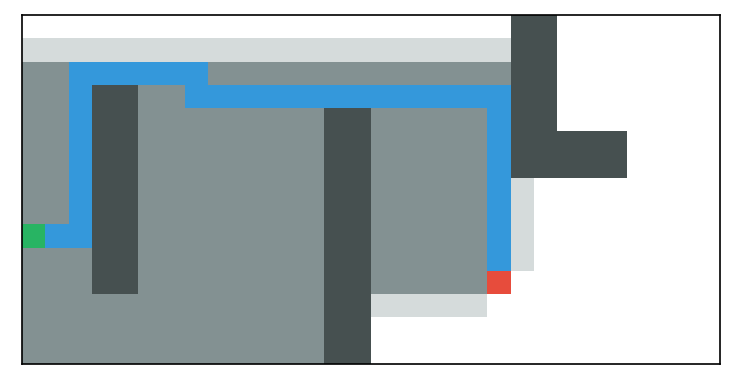

In [32]:
%time SimpleTest(AStar, 0, ManhattanDistance, OpenList, ClosedList)

Path found! Length: 36. Nodes created: 245. Number of steps: 215. Correct: True
Wall time: 21 ms


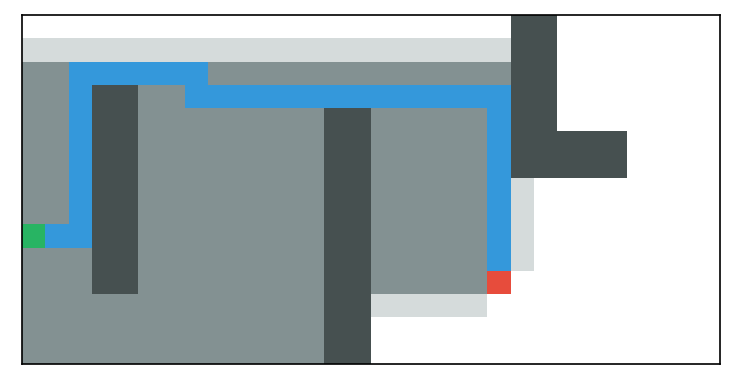

In [33]:
%time SimpleTest(AStar, 0, ManhattanDistance, OpenList, YourClosed)

Path found! Length: 36. Nodes created: 205. Number of steps: 150. Correct: True
Wall time: 21 ms


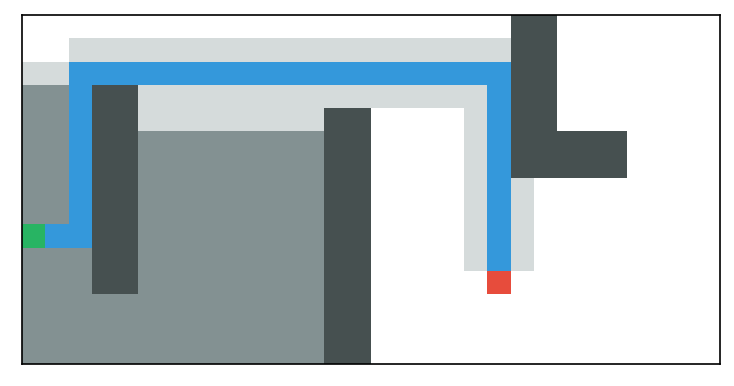

In [34]:
%time SimpleTest(AStar, 0, ManhattanDistance, YourOpen, YourClosed)

Path found! Length: 31.313708498984763. Nodes created: 223. Number of steps: 187. Correct: True
Wall time: 16.5 ms


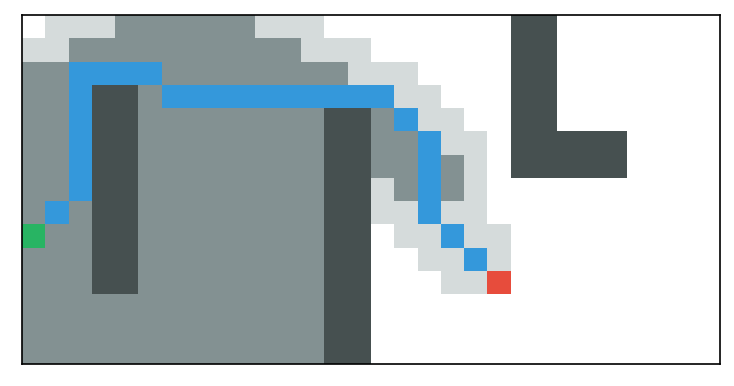

In [35]:
%time SimpleTest(AStar, 0, DiagonalDistance, YourOpen, YourClosed, True)

Path found! Length: 31.313708498984763. Nodes created: 233. Number of steps: 199. Correct: True
Wall time: 16.5 ms


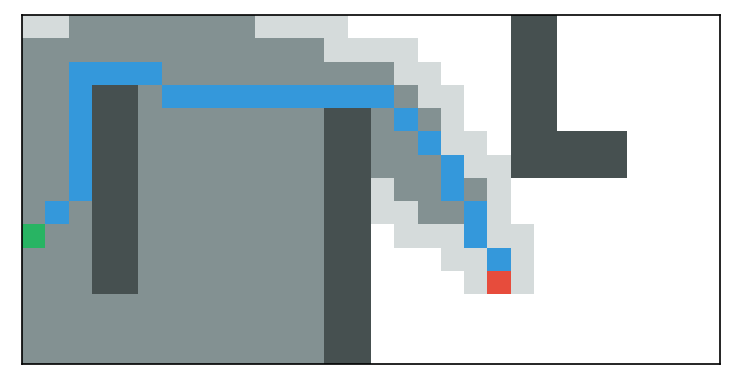

In [36]:
%time SimpleTest(AStar, 0, EuclideanDistance, YourOpen, YourClosed, True)

In [37]:
#running massive test of A* on 4-connected grids with Manhattan-distance heuristic
%time astStat = MassiveTest(AStar, ManhattanDistance, YourOpen, YourClosed, False)

Path found! Length: 64. Nodes created: 178. Number of steps: 65. Correct: True
Path found! Length: 197. Nodes created: 3478. Number of steps: 3341. Correct: True
Path found! Length: 462. Nodes created: 2904. Number of steps: 2164. Correct: True
Path found! Length: 498. Nodes created: 27348. Number of steps: 27045. Correct: True
Path found! Length: 479. Nodes created: 24221. Number of steps: 23455. Correct: True
Path found! Length: 402. Nodes created: 3632. Number of steps: 3062. Correct: True
Path found! Length: 721. Nodes created: 75050. Number of steps: 74525. Correct: True
Path found! Length: 678. Nodes created: 49830. Number of steps: 48860. Correct: True
Path found! Length: 683. Nodes created: 29534. Number of steps: 28092. Correct: True
Wall time: 3.28 s


In [38]:
#running massive test of A* on 8-connected grids with Manhattan-distance heuristic
%time astManhStat = MassiveTest(AStar, ManhattanDistance, YourOpen, YourClosed, True)

Path found! Length: 48.183766184073555. Nodes created: 164. Number of steps: 38. Correct: True
Path found! Length: 183.5269119345813. Nodes created: 3753. Number of steps: 3559. Correct: True
Path found! Length: 397.73001410241216. Nodes created: 7265. Number of steps: 6534. Correct: False
Path found! Length: 397.8305191658005. Nodes created: 21044. Number of steps: 20500. Correct: True
Path found! Length: 360.6711395993667. Nodes created: 1929. Number of steps: 1059. Correct: False
Path found! Length: 346.5929291125639. Nodes created: 5178. Number of steps: 4488. Correct: False
Path found! Length: 564.5950211536186. Nodes created: 65028. Number of steps: 64422. Correct: True
Path found! Length: 573.730014102412. Nodes created: 12310. Number of steps: 11348. Correct: False
Path found! Length: 619.7594513539351. Nodes created: 26921. Number of steps: 25924. Correct: False
Wall time: 3.47 s


In [39]:
#running massive test of A* on 8-connected grids with Euclidean-distance heuristic
%time astEuclidStat = MassiveTest(AStar, EuclideanDistance, YourOpen, YourClosed, True)

Path found! Length: 48.183766184073555. Nodes created: 546. Number of steps: 403. Correct: True
Path found! Length: 183.5269119345813. Nodes created: 5117. Number of steps: 4931. Correct: True
Path found! Length: 369.44574285495037. Nodes created: 24467. Number of steps: 23670. Correct: True
Path found! Length: 397.8305191658005. Nodes created: 25599. Number of steps: 25201. Correct: True
Path found! Length: 360.0853531617398. Nodes created: 19260. Number of steps: 18495. Correct: True
Path found! Length: 344.5929291125639. Nodes created: 16579. Number of steps: 16042. Correct: True
Path found! Length: 564.5950211536186. Nodes created: 71364. Number of steps: 70894. Correct: True
Path found! Length: 536.2396820942909. Nodes created: 36943. Number of steps: 36244. Correct: True
Path found! Length: 589.2741699796965. Nodes created: 57286. Number of steps: 56128. Correct: True
Wall time: 5.97 s


In [40]:
#running massive test of A* on 8-connected grids with Diagonal-distance heuristic
%time astDiagStat = MassiveTest(AStar, DiagonalDistance, YourOpen, YourClosed, True)

Path found! Length: 48.183766184073555. Nodes created: 286. Number of steps: 155. Correct: True
Path found! Length: 183.5269119345813. Nodes created: 4759. Number of steps: 4581. Correct: True
Path found! Length: 369.44574285495037. Nodes created: 16731. Number of steps: 15786. Correct: True
Path found! Length: 397.8305191658005. Nodes created: 24282. Number of steps: 23857. Correct: True
Path found! Length: 360.0853531617398. Nodes created: 12696. Number of steps: 11866. Correct: True
Path found! Length: 344.5929291125639. Nodes created: 13457. Number of steps: 12918. Correct: True
Path found! Length: 564.5950211536186. Nodes created: 69557. Number of steps: 69063. Correct: True
Path found! Length: 536.2396820942909. Nodes created: 31305. Number of steps: 30562. Correct: True
Path found! Length: 589.2741699796966. Nodes created: 47115. Number of steps: 45829. Correct: True
Wall time: 5.5 s


# Analysis of results
First of all lets compare Dijkstra and A* algorithms on 4-connected grids

Secondly lets compare A* with different heuristics on 8-connected grids

Additionally you can compare Dijkstra and A* algorithms on 8-connected grids or A* with different heuristics on 4-connected grids

![2](./Image/3.png)

## Part 1. Dijkstra vs A* on 4-connected grids

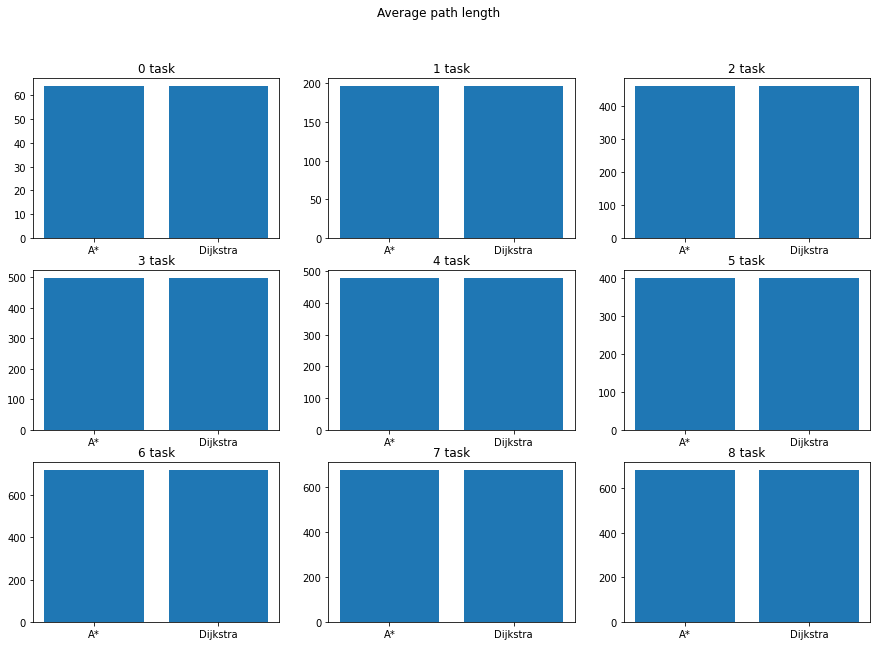

In [41]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average path length')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['A*', 'Dijkstra']
    lens = [astStat['len'][i], dijkStat['len'][i]]
    ax.bar(alg, lens)
plt.show()

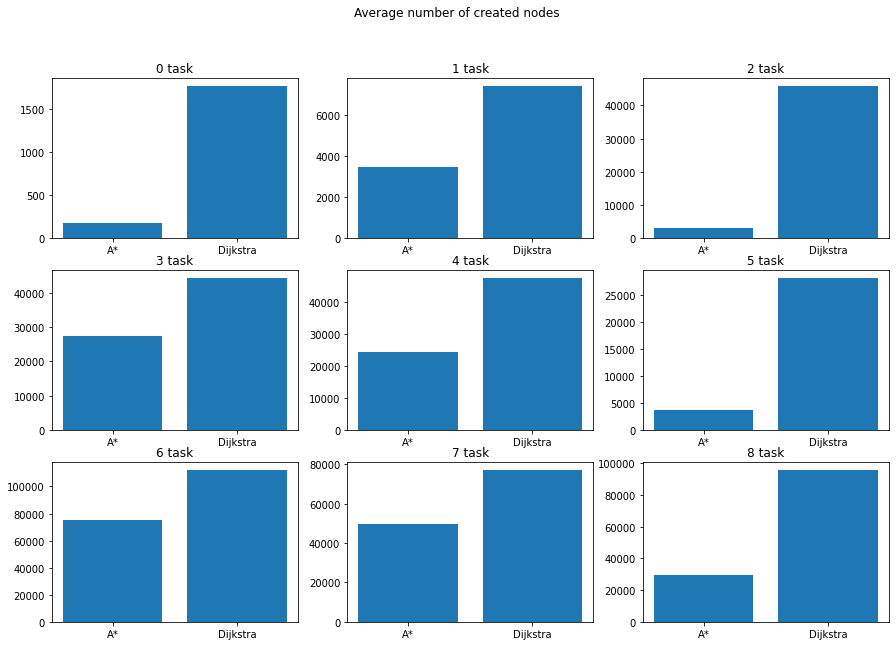

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average number of created nodes')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['A*', 'Dijkstra']
    ncs = [astStat['nc'][i], dijkStat['nc'][i]]
    ax.bar(alg, ncs)
plt.show()

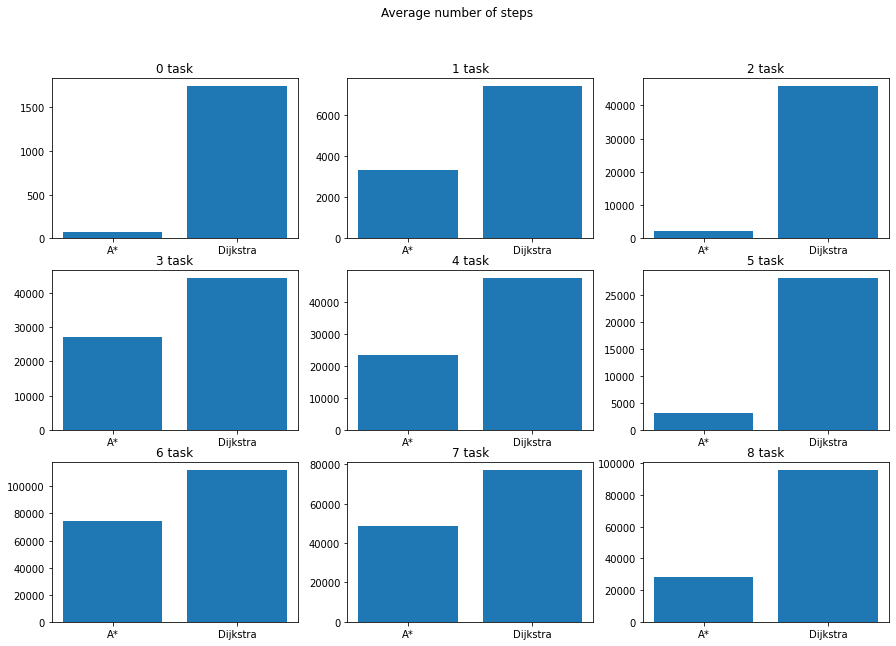

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average number of steps')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['A*', 'Dijkstra']
    sts = [astStat['st'][i], dijkStat['st'][i]]
    ax.bar(alg, sts)
plt.show()

## Part 2. A* with different heuristics on 8-connected grids

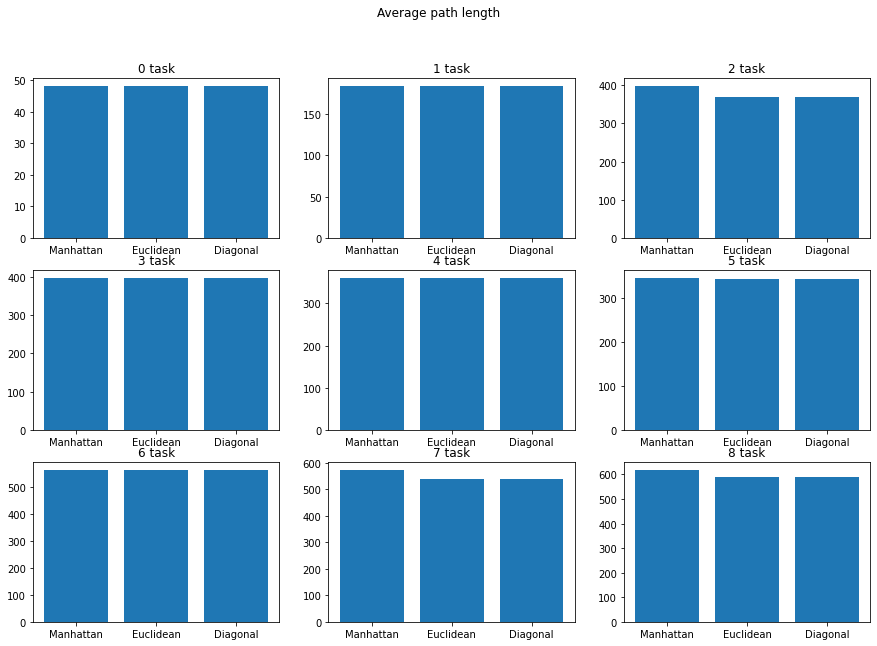

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average path length')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['Manhattan', 'Euclidean', 'Diagonal']
    lens = [astManhStat['len'][i], astEuclidStat['len'][i], astDiagStat['len'][i]]
    ax.bar(alg, lens)
plt.show()

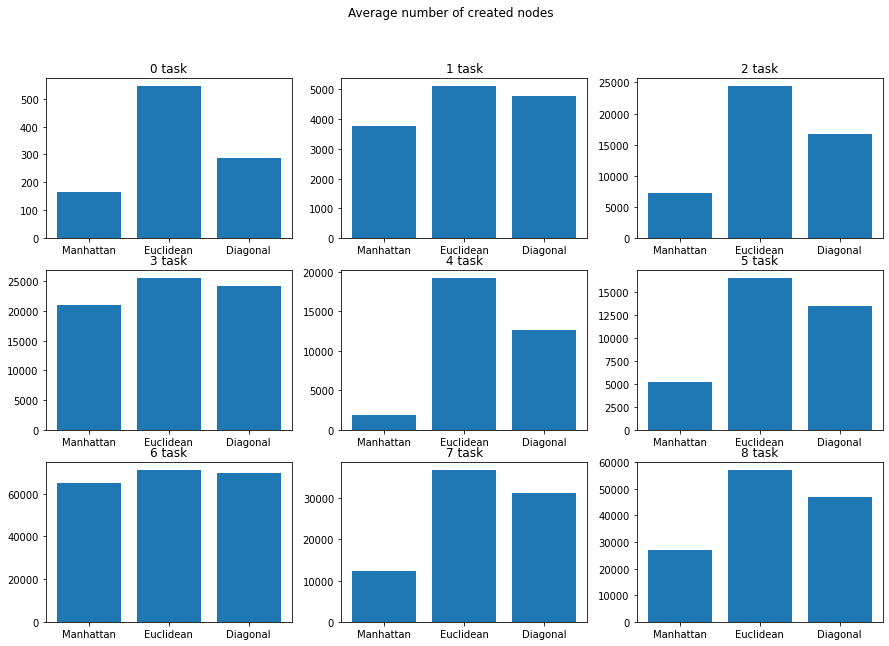

In [45]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average number of created nodes')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['Manhattan', 'Euclidean', 'Diagonal']
    ncs = [astManhStat['nc'][i], astEuclidStat['nc'][i], astDiagStat['nc'][i]]
    ax.bar(alg, ncs)
plt.show()

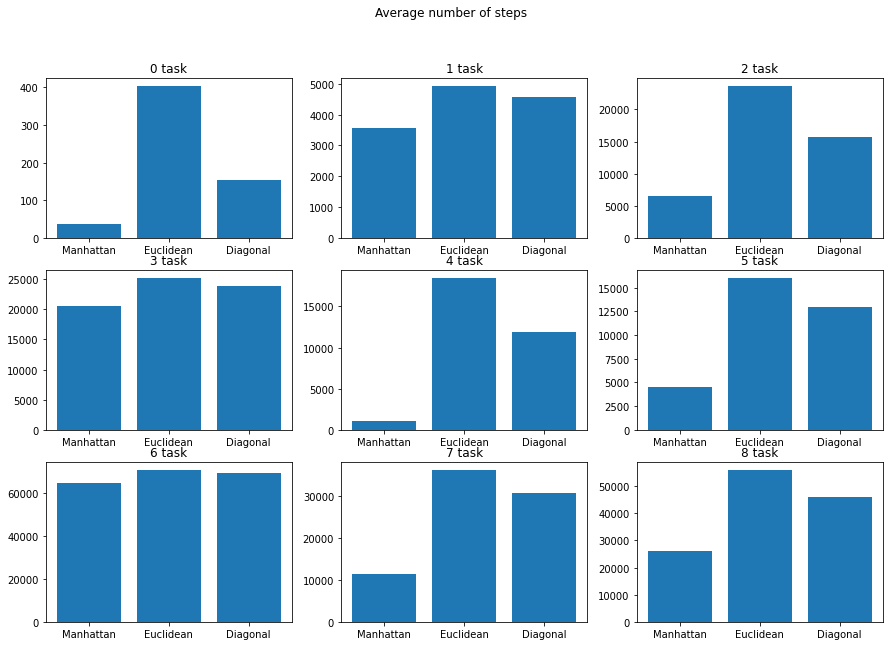

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
fig.suptitle('Average number of steps')
for i in range(9):
    ax = axs[i // 3, i % 3]
    ax.set_title(str(i) + " task")
    alg = ['Manhattan', 'Euclidean', 'Diagonal']
    ncs = [astManhStat['st'][i], astEuclidStat['st'][i], astDiagStat['st'][i]]
    ax.bar(alg, ncs)
plt.show()